**ALMA-IMF continuum practical excercise** 

ALMA-IMF is a Large Program aimed at measuring the core mass function, and understanding its relation to the origin of the stellar initial mass function. 

Project webpage: \
https://www.almaimf.com \
GitHub repository with data reduction pipeline. Further processing tools will be added: \
https://github.com/ALMA-IMF \
Survey overview paper: \
https://ui.adsabs.harvard.edu/abs/2022A%26A...662A...8M/abstract \
Paper with the continuum data release (the one we are using): \
https://ui.adsabs.harvard.edu/abs/2022A%26A...662A...9G/abstract \
Paper with the line data release (recently accepted): \
https://ui.adsabs.harvard.edu/abs/2023arXiv230614710C/abstract


This Notebook uses ALMA-IMF continuum images of the same star formation region in two diferent bands: Band (3 mm, $\sim100$ GHz) and Band 6 (1.3 mm, $\sim230$ GHz). 

You will mesure the spectral index $\alpha$ between the images, and separate emission in three types: dominated by dust, dominated by free-free, and a mixture with unknown proportions of each. \
The spectral index $\alpha$ is defined from $F_\nu \propto \nu^\alpha$ \
$\Rightarrow$ $\alpha = \log (F_{\nu,2}/F_{\nu,1}) / \log (\nu_2 / \nu_1)$

In star formation regions, in the microwave radio and sub(mm) ($\sim 1$ to few $\times 100$ GHz), dominant continuum emission mechanisms are:  \
Dust, $\alpha_\mathrm{dust} \approx 2$ ($\tau >> 1$) to $\approx 4$ ($\tau << 1$). \
Free-free from ioinzed gas, $\alpha_\mathrm{ff} \approx -0.1$ ($\tau << 1$) to $\approx 2$ ($\tau >> 1$). \
At low frequencies ($<10$  GHz), there could be a bit of synchrotron emission with $\alpha_\mathrm{synch} < -1$.




If you get bored after you finish, you could try another of the 15 ALMA-IMF protocluster fields. \
The continuum data release is hosted in Zenodo: \
https://zenodo.org/record/5702966 \
A line cube data set has just been released, hosted in Dataverse: \
https://dataverse.harvard.edu/dataverse/alma-imf \
You could analyze the cubes using CARTA as in the HI excercise, or with a variety of Python tools like in this excersise. 

In [15]:
# Import dependencies
from astropy.io import fits
from astropy.stats import mad_std
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from importlib import reload

# We also need to import a couple of local modules
#Small plotting library for this excercise needs to be in path: 
#import map_plots
#reload(map_plots)
from map_plots import *
# And a library for geometry manipulations
#import geometry
#reload(geometry)
from geometry import *


In [16]:
# Define image filenames
filepath = '/home/roberto/ALMA_IMF/freefree'
file_3mm = os.path.join(filepath,'W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits')
file_1mm = os.path.join(filepath,'W51-E_B6_uid___A001_X1296_X213_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits')

In [17]:
#Read in file data and headers
data_3mm = fits.getdata(file_3mm)
data_1mm = fits.getdata(file_1mm)

hd_3mm = fits.getheader(file_3mm)
hd_1mm = fits.getheader(file_1mm)

In [5]:
#We now inspect the image headers
#print(hd_3mm)
#print(hd_1mm)
print('The beamsize at 3mm is BMAJ = {0:.4f} arcsec, BMIN = {1:.4f} arcsec'.
      format(hd_3mm['BMAJ']*3600,hd_3mm['BMIN']*3600))
print('The beamsize at 1mm is BMAJ = {0:.4f} arcsec, BMIN = {1:.4f} arcsec'.
      format(hd_1mm['BMAJ']*3600,hd_1mm['BMIN']*3600))
print('\n')
print('The spatial geometry at 3mm is {0} x {1} pixels'.
      format(hd_3mm['NAXIS1'],hd_1mm['NAXIS2']))
print('The spatial geometry at 1mm is {0} x {1} pixels'.
      format(hd_1mm['NAXIS1'],hd_1mm['NAXIS2']))
#Another way of looking at the geometry of the image is just printing the array shape
print('\n')
print(data_3mm.shape)
print(data_1mm.shape)

NameError: name 'hd_3mm' is not defined

In [15]:
#We will have to convolve the image with the smaller beam (3mm) to the larger beam (1mm)
im3mm_conv = convol(file_3mm, file_1mm)

#And upsample the image with less pixels (1mm) to more pixels (3mm)
im1mm_regr = regrid(file_1mm, file_3mm) 

Beam: BMAJ=0.289185523986816 arcsec BMIN=0.26638138294221597 arcsec BPA=71.47632598877 deg
Beam: BMAJ=0.343147188425076 arcsec BMIN=0.271076768636688 arcsec BPA=25.91439628601 deg
Created /media/roberto/ADATA SE760/ISYA23/ALMA_lab/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.conv.fits


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Created /media/roberto/ADATA SE760/ISYA23/ALMA_lab/W51-E_B6_uid___A001_X1296_X213_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.regr.fits


In [16]:
# From now on we will use the convolved/regridded images: 
file_3mm_conv = os.path.join(filepath,im3mm_conv)
file_1mm_regr = os.path.join(filepath,im1mm_regr)

#Read in file data and headers
data_3mm_conv = fits.getdata(file_3mm_conv)
data_1mm_regr = fits.getdata(file_1mm_regr)

# Read in headers
hd_3mm_conv = fits.getheader(file_3mm_conv)
hd_1mm_regr = fits.getheader(file_1mm_regr)

In [17]:
# We corroborate that image geometry is homogeneized
print('The *new* beamsize at 3mm is BMAJ = {0:.4f} arcsec, BMIN = {1:.4f} arcsec'.
      format(hd_3mm_conv['BMAJ']*3600,hd_3mm_conv['BMIN']*3600))
print('The *unchanged* beamsize at 1mm is BMAJ = {0:.4f} arcsec, BMIN = {1:.4f} arcsec'.
      format(hd_1mm_regr['BMAJ']*3600,hd_1mm_regr['BMIN']*3600))

print(data_3mm_conv.shape)
print(data_1mm_regr.shape)

The *new* beamsize at 3mm is BMAJ = 0.3431 arcsec, BMIN = 0.2711 arcsec
The *unchanged* beamsize at 1mm is BMAJ = 0.3431 arcsec, BMIN = 0.2711 arcsec
(1, 1, 4800, 4800)
(1, 1, 4800, 4800)


In [19]:
# Measure the noise in the images. 
# A good metric is the Median Absolute Deviation, normalized as a standard deviation, of the image
# The noise will be used to improve plots and to define masks where the spectral index will be measured. 
noise_3mm = mad_std(data_3mm_conv, ignore_nan=True)
noise_1mm = mad_std(data_1mm_regr, ignore_nan=True)
print('Noise in the 3mm image is {:.3e} Jy/beam'.format(noise_3mm))
print('Noise in the 1mm image is {:.3e} Jy/beam'.format(noise_1mm))

Noise in the 3mm image is 1.932e-04 Jy/beam
Noise in the 1mm image is 5.793e-04 Jy/beam


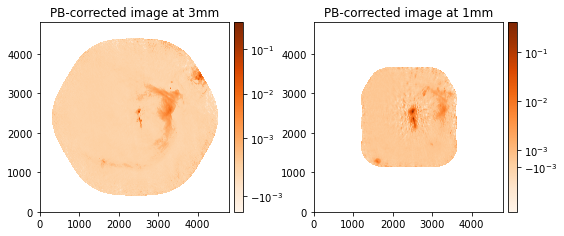

In [29]:
#Plot the images
orig_fig = twoband_maps(data_3mm_conv, data_1mm_regr, noise_lowfreq=0.5*noise_3mm, 
                        noise_highfreq=0.5*noise_1mm, title_lowfreq='PB-corrected image at 3mm',
                        title_highfreq='PB-corrected image at 1mm')

In [114]:
# We now apply a noise-based mask, because we cannot measure the spectral index in noisy areas. 
thr_3mm = 1 #sigma threshold
masked_3mm_conv = np.where(data_3mm_conv > thr_3mm*noise_3mm, data_3mm_conv, np.nan)

thr_1mm = 2 #sigma threshold
masked_1mm_regr = np.where(data_1mm_regr > thr_1mm*noise_1mm, data_1mm_regr, np.nan)

In [115]:
#The spectral index alpha is defined as alpha = log10(F_high/F_low) / log10(nu_high/nu_low)

#Exact frequencies of images are:  
nu_3mm = hd_3mm['CRVAL3'] #Hz
nu_1mm = hd_1mm['CRVAL3'] #Hz

#Calculate spectral index: 
spix_data = np.log10(masked_1mm_regr / masked_3mm_conv) / np.log10(nu_1mm / nu_3mm)
#Take only the central part of the array to avoid edges with nan, and drop dummy axes
spix_data = spix_data.squeeze()[1000:4000,1000:4000]

6.1889325500939245
-1.805173249414678


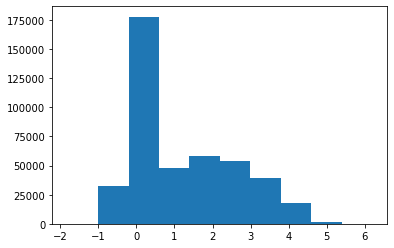

In [126]:
#Analize the distribution of spectral index (alpha) values
#Dust emission will have alpha ~ [2,4]
#Free-free from ionized gas will have alpha ~ [-0.1, 2]
#Synchrotron emission will have alpha << 0
#Find min and max
print(np.nanmax(spix_data))
print(np.nanmin(spix_data))
#Create a histogram
valid_values = spix_data[~np.isnan(spix_data)]
plt.hist(valid_values, bins=10);

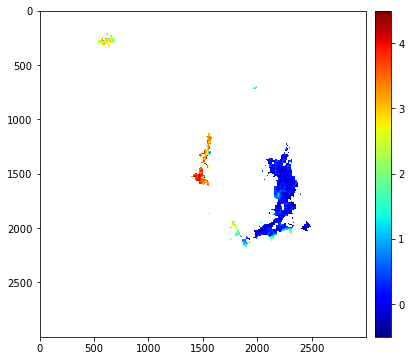

In [134]:
fig = plt.figure(figsize=(8,6))
plt.imshow(spix_data, cmap='jet', vmin=-0.5, vmax=4.5)
plt.colorbar(pad=0.02);

In the previous plot: 
- To the right we can see an arc (we know it's part of a broken shell) of ionized gas, emitting free-free radiation. 
- Around the center we see an elongated structure (filament) of dust emission, compact spots of free-free emission (known small HII regions) are also seen.  
- In the top-left we also see a roundish structure with a mixture of free-free and dust emission. 